<a href="https://colab.research.google.com/github/Joseph-Luper-Tsenum/Deep-Learning-CNN-for-Predicting-Transcription-Factor-Binding-Site-in-DNA/blob/main/Deep_Learning_(CNN)_for_Predicting_Transcription_Factor_Binding_Site_in_DNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning (CNN) for Predicting Transcription Factor Binding Motifs in DNA Sequences

This result has been reproduced from the paper **A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou et. al

The input data used in this model was gotten from the paper 

## Outline 

* **Steps taken to Generate this CNN Model**
* ** 0. Background ** 
* **1. Curate the Data**
* **2. Select the Architecture and Train**
* **3. Evaluate**
* **4. Interpret**

## 0. Background



Here a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not has been designed. Here, the longer DNA sequences are the *independent variables* (or *predictors*), while the positive or negative response of the assay is the *dependent variable* (or *response*).

A simulated data that consists of DNA sequences of length 50 bases has been used, and is labeled with 0 or 1 depending on the result of the assay. The goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(Spoiler alert: the true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural network doesn't know this.)


## 1. Curate the Data

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-01.png?raw=true)

In order to train the neural network, the data must be loaded and preprocessed which consists of DNA sequences and their corresponding labels. By processing this data, the network will learn to distinguish sequences that bind to the transcription factor from those that do not. The data will then be split into three different sub-datasets:

(1) Training dataset: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

(2) Validation dataset: a second dataset used to minimize overfitting. The weights of the network are not adjusted with this data set. After each training cycle, if the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then there is overfitting on the neural network.

(3) Testing dataset: is a third dataset not included in the training nor validation data sets. After all the training and validation cycles are complete, this dataset is used only for testing the final solution in order to measure the actual predictive power of the neural network on new examples.

-----------

The first step was to load the simulated data from an external repository.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


The next  step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors). 

To get each DNA sequence in the form of a matrix, _one-hot encoding_ was used, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. A "1" was placed in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. These 4-dimensional vectors were concatenate together along the bases in the sequence to form a matrix. 

In the cell below, one-hot encode on the simulated DNA sequences was carried out, and show an example of what the one-hot encoded sequence looks like:

In [26]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Similarly, the labels were loaded (_response variables_). In this case, the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. While the labels could be used as a vector, it is often easier to similarly one-hot encode the labels, just as done on the features. This was carried out here:

In [27]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


The data was then split into training and test sets. The purpose of the test set is to ensure that the performance of the model on new data can be observed, not seen previously during training. At a later step, the training set was further partitined into a training and validation set.

In [28]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

## 2. Select the Architecture and Train

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)

Next, a neural network architecture to train the model was then choosen. A simple 1D convolutional neural network (CNN) was chosen, which is commonly used in deep learning for functional genomics applications.

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In this dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of a transcription factor binding site). 

Deep learning library `Keras` was used. `Keras` has been integrated into `TensorFlow`,  which makes it very easy to construct neural networks. Also, the only need here is to specify the kinds of layers you want to include in the network, and the dimensionality of each layer. The CNN generated here consists of the following layers:

- _Conv1D_: Here, the convolutional layer was defined to have 32 filters of size 12 bases.

- _MaxPooling1D_: After the convolution, a pooling layer was used to down-sample the output of the each of the 32 convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters. 

- _Dense_: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

The details of the architecture of the neural network created can be seen by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in the network. 

In [29]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
            input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 39, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4624      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


Now, the neural network can be trained. The training set was further divided into a training and validation set. Only the reduced training set was trained, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

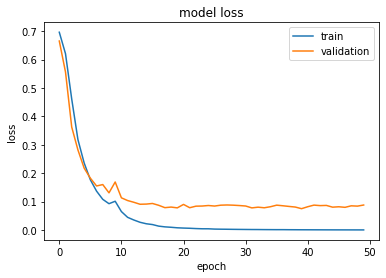

In [30]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Similarly, a plot of the accuracy of the neural network on the binary classification task can be done. The metric used in this is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Other metrics may be used in different tasks -- for example, the _mean squared error_ is typically used to measure the accuracy for continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight and systolic blood pressure).

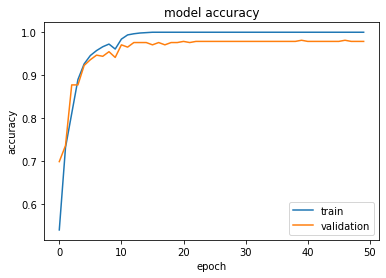

In [31]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## 3. Evaluate

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, the model was evaluated on the test set and a plot of the results was done as a confusion matrix. Nearly every test sequence should be correctly classified.

Confusion matrix:
 [[258   1]
 [  1 240]]


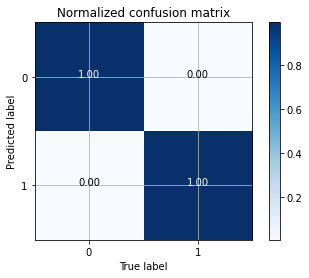

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

## 4. Interpret

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-31.png?raw=true)

The results showed that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But is it possible to understand _why_ the neural network classifies a training point in the way that it does? To do so, a simple _saliency map_ can be computed, which is the gradient of the model's prediction with respect to each individual nucleotide. 

In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides form the binding motive that need to be identified.

In [33]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

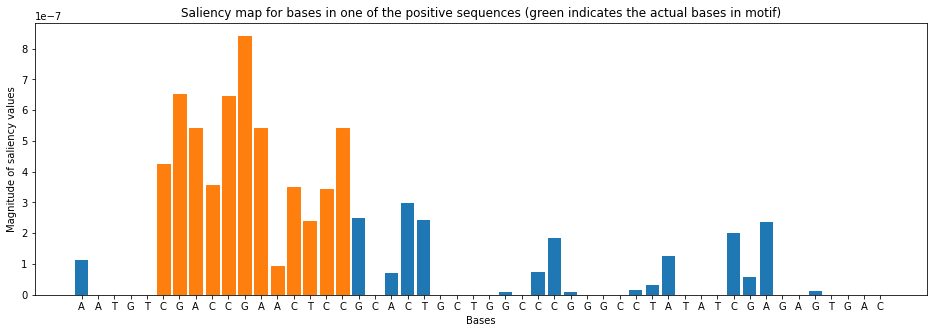

In [34]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');

The results above should show high saliency values for the bases _CGACCGAACTCC_ appearing in the DNA sequence. If you recall from the top of the document, this is exactly the motif that was embedded in the positive sequences! The raw saliency values may be non-zero for other bases as well -- the gradient-based saliency map method is not perfect, and there are other more complex interpretation methods that are used in practice to obtain better results.  

Furthermore, other architectures for this neural network can be explored to see if the performance on the validation dataset cab be improved. A different _hyper-parameters_ can be chosen, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the binding motif.